In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from seaborn import regplot
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('C:/Users/richarj2/Downloads/2014_player_data_standardized.csv')
df.head()

,Unnamed: 0,player_name,minutes_played,goals,npg,assists,xG,xA,npxG,xG90,...,yellow_cards,red_cards,xGBuildup,xGChain,market_value_in_eur,height_in_cm,age_in_months_2015,points_per_game,team_rank,player_performance_valuation_standardized
0,1,David Silva,2682,12,12,7,9.096988,10.388413,9.096988,0.305268,...,8,0,16.633573,29.144278,50000.0,178.0,341.0,1.927632,13,11.325041
1,2,Graziano Pellè,3291,12,12,2,18.616503,4.481624,18.616503,0.509111,...,6,0,5.598169,24.785647,100000.0,194.0,356.0,1.447368,143,7.807678
2,3,Jakub Blaszczykowski,599,0,0,0,1.210137,0.883586,1.210137,0.181824,...,0,0,2.687145,4.451465,25000.0,176.0,351.0,1.959559,18,6.198375
3,4,Massimo Maccarone,2507,10,9,7,8.975993,7.552497,8.214694,0.322233,...,4,0,3.106277,14.702128,150000.0,180.0,426.0,1.157895,221,5.596764
4,5,Emanuele Giaccherini,292,0,0,0,0.334447,0.555395,0.334447,0.103083,...,2,0,0.334591,0.962826,75000.0,167.0,358.0,1.072368,107,5.115847


In [3]:
features = ['minutes_played', 'goals', 'npg', 'assists', 'xG', 'xA', 'npxG', 'xG90', 'xA90', 'npxG90', 'shots', 
            'key_passes', 'xGBuildup', 'xGChain', 'age_in_months_2015', 'market_value_in_eur', 'points_per_game', 'position_x']
target = 'player_performance_valuation_standardized'

X = df[features]
y = df[target]
y = np.log1p(df[target])  # Use np.expm1 to reverse

# Feature Engineering
X['npxG_minus_market_value_in_eur'] = X['npxG'] - X['market_value_in_eur']
X['shots_minus_market_value_in_eur'] = X['shots'] - X['market_value_in_eur']
X['xG_minus_market_value_in_eur'] = X['xG'] - X['market_value_in_eur']
X['npg_minus_market_value_in_eur'] = X['npg'] - X['market_value_in_eur']
X['goals_minus_market_value_in_eur'] = X['goals'] - X['market_value_in_eur'] #24.31 test r2
X['xG90_minus_market_value_in_eur'] = X['xG90'] - X['market_value_in_eur'] #27.47

#X['shots_plus_npxG_minus_market_value_in_eur'] = X['shots'] + X['npxG'] - X['market_value_in_eur']

X = X.drop(['npxG', 'market_value_in_eur', 'shots', 'xG', 'npg', 'goals', 'xG90'], axis=1)

# Separate numeric and categorical
X_number = X.select_dtypes(include=['number'])
X_categorical = X.select_dtypes(include=['object'])

# Normalize
X_number = (X_number - X_number.mean()) / X_number.std(ddof=0)

# One-hot encode
X_categorical = pd.get_dummies(X_categorical, dtype='int')

X = pd.concat([X_number, X_categorical], axis=1) #X_categorical

X = X.dropna()
y = y.loc[X.index]
X

C:\Users\richarj2\AppData\Local\Temp\ipykernel_13804\3227809435.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['npxG_minus_market_value_in_eur'] = X['npxG'] - X['market_value_in_eur']
C:\Users\richarj2\AppData\Local\Temp\ipykernel_13804\3227809435.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['shots_minus_market_value_in_eur'] = X['shots'] - X['market_value_in_eur']
C:\Users\richarj2\AppData\Local\Temp\ipykernel_13804\3227809435.py:12: SettingWithCopyWarning: 
A value is trying to be set on

,minutes_played,assists,xA,xA90,npxG90,key_passes,xGBuildup,xGChain,age_in_months_2015,points_per_game,...,position_x_D S,position_x_F,position_x_F M,position_x_F M S,position_x_F S,position_x_GK,position_x_GK S,position_x_M,position_x_M S,position_x_S
0,1.054625,2.421894,4.609537,2.844067,1.181179,4.137271,4.086002,4.219969,0.406308,1.359152,...,0,0,0,0,0,0,0,1,0,0
1,1.703004,0.175410,1.507777,0.410166,2.433312,1.435611,0.604047,3.422880,0.683164,-0.078120,...,0,0,0,0,1,0,0,0,0,0
2,-1.163064,-0.723183,-0.381617,0.519979,0.422906,-0.108195,-0.314456,-0.295752,0.590878,1.454700,...,0,0,0,0,0,0,0,0,1,0
3,0.868309,2.421894,3.120347,2.009878,1.117512,1.821562,-0.182209,1.578847,1.975157,-0.944421,...,0,0,0,0,1,0,0,0,0,0
4,-1.489915,-0.723183,-0.553956,0.933708,-0.060768,-0.383874,-1.056748,-0.933740,0.720078,-1.200373,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,-1.785890,-0.723183,-0.845603,-0.909488,-0.693968,-0.935234,-1.139503,-1.096593,-1.439397,1.477284,...,0,0,0,0,0,0,0,0,0,1
580,0.928995,0.624707,0.183627,-0.168706,0.223058,0.829116,-0.051942,0.389998,-0.553459,-0.327510,...,0,0,0,1,0,0,0,0,0,0
581,-1.788020,-0.723183,-0.845603,-0.909488,-0.693968,-0.935234,-1.162320,-1.109818,-1.642425,1.821835,...,0,0,0,0,0,0,0,0,0,1
582,1.194096,-0.723183,-0.732504,-0.835290,-0.693968,-0.769826,-0.681950,-0.792012,-0.830314,1.477284,...,0,0,0,0,0,1,0,0,0,0


In [4]:
print({'mean':df['player_performance_valuation_standardized'].mean(),        # there are outliers, need to drop them for better R2
       'median':df['player_performance_valuation_standardized'].median(),
       'std':df['player_performance_valuation_standardized'].std(),
       'min':df['player_performance_valuation_standardized'].min(),
       'max':df['player_performance_valuation_standardized'].max()
       })

{'mean': -8.218935425696282e-13, 'median': -0.330384607961434, 'std': 1.0008572654810513, 'min': -0.4701931531580386, 'max': 11.325040855710744}


In [5]:
# Compute IQR
Q1 = y.quantile(0.25)
Q3 = y.quantile(0.75)
IQR = Q3 - Q1

# Define upper and lower bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
mask = (y >= lower_bound) & (y <= upper_bound)
X_filtered = X.loc[mask]
y_filtered = y.loc[mask]

print(f"Removed {len(y) - len(y_filtered)} outliers from target.")
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, train_size=0.8, random_state=0
)

Removed 40 outliers from target.


In [6]:
# Create pipeline with StandardScaler, PCA, and KNN Regressor
pipe = Pipeline([
    ('pca', PCA()),
    ('knn', KNeighborsRegressor())
])

# Parameter grid for GridSearchCV
param_grid = {
    'pca__n_components': [0.90, 0.95, 0.99],
    'knn__n_neighbors': list(range(1, 51, 2)),
    'knn__weights': ['uniform', 'distance']
}

# GridSearchCV setup
knnCV = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)

# Fit model on training data
knnCV.fit(X_train, y_train)

# Best parameters and CV R² (log space)
print("Best parameters:", knnCV.best_params_)
print("Best CV R² (log scale):", knnCV.best_score_)

# Predict on test set (log scale)
y_pred_log = knnCV.best_estimator_.predict(X_test)

# Reverse log transform to original scale
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

# Calculate test R² and MSE on original scale
test_r2_orig = r2_score(y_test_orig, y_pred)
mse_orig = mean_squared_error(y_test_orig, y_pred)

print(f"Test R² (original scale): {test_r2_orig:.4f}")
print(f"Test MSE (original scale): {mse_orig:.4f}")

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Best parameters: {'knn__n_neighbors': 15, 'knn__weights': 'distance', 'pca__n_components': 0.99}
Best CV R² (log scale): 0.22280856275228614
Test R² (original scale): 0.2747
Test MSE (original scale): 0.0639


C:\Users\richarj2\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\richarj2\AppData\Local\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


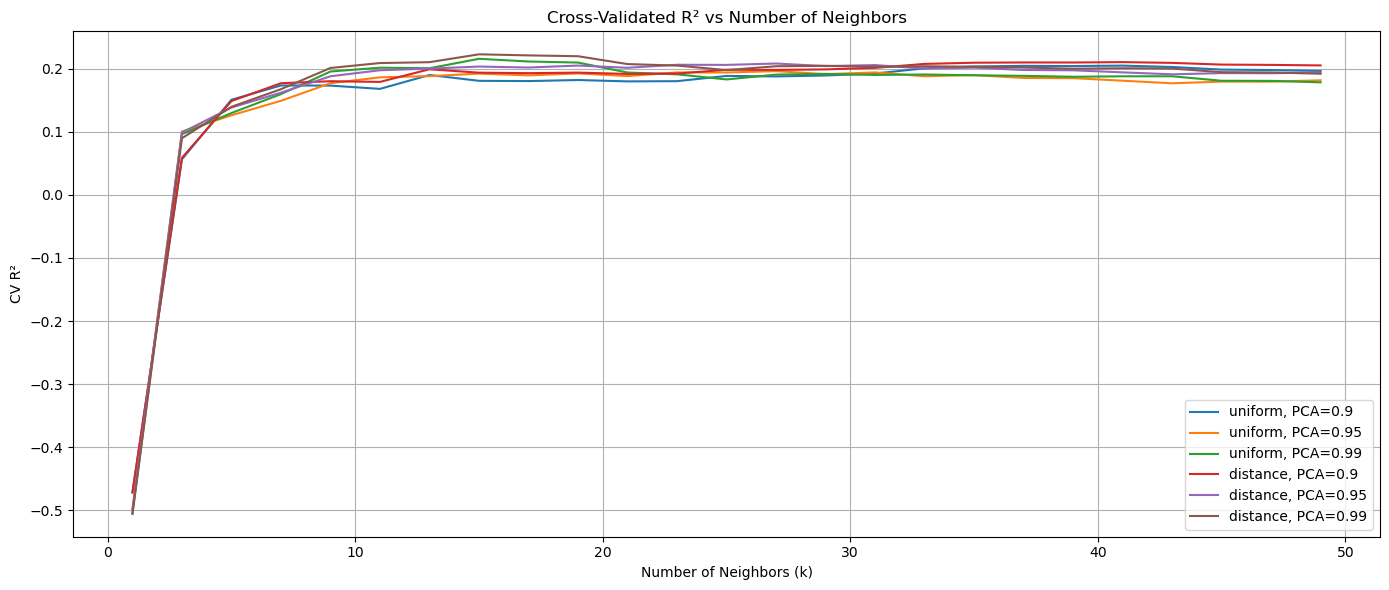

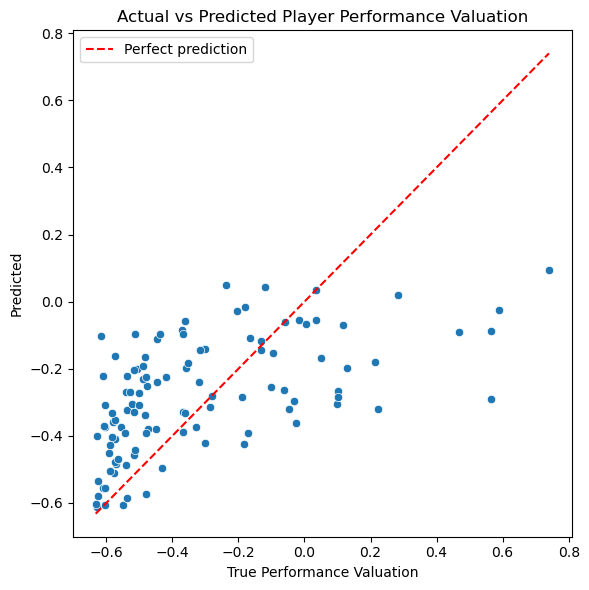

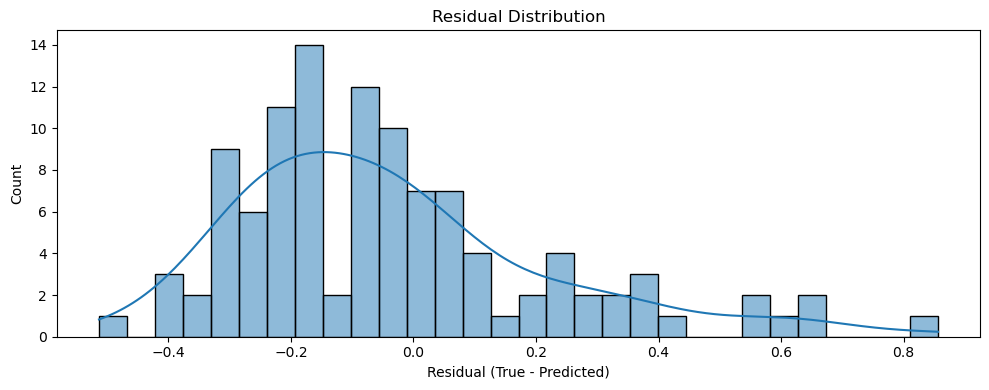

In [7]:
# Convert results to DataFrame
cv_results = pd.DataFrame(knnCV.cv_results_)

# 1. Plot R² vs k for each weight type and PCA setting
plt.figure(figsize=(14, 6))
for weight in ['uniform', 'distance']:
    subset = cv_results[cv_results['param_knn__weights'] == weight]
    for var in subset['param_pca__n_components'].unique():
        sub = subset[subset['param_pca__n_components'] == var]
        plt.plot(sub['param_knn__n_neighbors'], sub['mean_test_score'],
                 label=f'{weight}, PCA={var}')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('CV R²')
plt.title('Cross-Validated R² vs Number of Neighbors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 2. Actual vs Predicted plot
y_pred = knnCV.best_estimator_.predict(X_test)

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
         'r--', label='Perfect prediction')
plt.xlabel('True Performance Valuation')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Player Performance Valuation')
plt.legend()
plt.tight_layout()
plt.show()

# 3. Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 4))
sns.histplot(residuals, bins=30, kde=True)
plt.title('Residual Distribution')
plt.xlabel('Residual (True - Predicted)')
plt.tight_layout()
plt.show()

In [8]:
# Only keep numeric columns from the original DataFrame
numeric_df = df[features + [target]].select_dtypes(include=['float64', 'int64'])

# Compute correlation with the target
correlations = numeric_df.corr()[target].sort_values(ascending=False)

print("Feature-to-Target Correlations (Numeric Only):")
print(correlations)


Feature-to-Target Correlations (Numeric Only):
player_performance_valuation_standardized    1.000000
npxG                                         0.289630
xG                                           0.272390
shots                                        0.264931
xGChain                                      0.263632
npg                                          0.258324
goals                                        0.246679
xA                                           0.243284
key_passes                                   0.229579
xG90                                         0.197427
npxG90                                       0.194417
xA90                                         0.184793
age_in_months_2015                           0.172578
xGBuildup                                    0.139870
assists                                      0.123793
minutes_played                               0.070580
points_per_game                             -0.049039
market_value_in_eur                

In [9]:
import pandas as pd
import numpy as np
from itertools import combinations

# Copy original numeric features
X_numeric_base = X.select_dtypes(include=[np.number]).copy()
target = y.copy()

# Containers for new features
new_features = {}

# Generate pairwise feature combinations
for f1, f2 in combinations(X_numeric_base.columns, 2):
    # Safely create interactions
    try:
        new_features[f'{f1}_plus_{f2}'] = X_numeric_base[f1] + X_numeric_base[f2]
        new_features[f'{f1}_minus_{f2}'] = X_numeric_base[f1] - X_numeric_base[f2]
        new_features[f'{f1}_times_{f2}'] = X_numeric_base[f1] * X_numeric_base[f2]
        # Avoid division by zero
        with np.errstate(divide='ignore', invalid='ignore'):
            new_features[f'{f1}_div_{f2}'] = np.where(X_numeric_base[f2] != 0, X_numeric_base[f1] / X_numeric_base[f2], np.nan)
    except Exception as e:
        print(f"Error with pair ({f1}, {f2}): {e}")
        continue

# Combine all new features at once — avoids fragmentation
X_combined = pd.concat([X_numeric_base, pd.DataFrame(new_features)], axis=1)

# Compute correlations with target
correlations = []
for col in X_combined.columns:
    corr = np.corrcoef(X_combined[col].fillna(0), target)[0, 1]
    correlations.append((col, corr))

# Sort and display top correlations
correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)

print("Top 20 most correlated new features with target:")
for name, corr in correlations[:20]:
    print(f"{name}: {corr:.4f}")


Top 20 most correlated new features with target:
npxG90_plus_shots_minus_market_value_in_eur: 0.3807
npxG90_plus_goals_minus_market_value_in_eur: 0.3807
npxG90_plus_xG_minus_market_value_in_eur: 0.3807
npxG90_plus_npg_minus_market_value_in_eur: 0.3807
npxG90_plus_npxG_minus_market_value_in_eur: 0.3807
npxG90_plus_xG90_minus_market_value_in_eur: 0.3807
xGChain_plus_shots_minus_market_value_in_eur: 0.3764
xGChain_plus_xG_minus_market_value_in_eur: 0.3764
xGChain_plus_npxG_minus_market_value_in_eur: 0.3764
xGChain_plus_npg_minus_market_value_in_eur: 0.3764
xGChain_plus_goals_minus_market_value_in_eur: 0.3764
xGChain_plus_xG90_minus_market_value_in_eur: 0.3764
xA_plus_shots_minus_market_value_in_eur: 0.3730
xA_plus_xG_minus_market_value_in_eur: 0.3730
xA_plus_goals_minus_market_value_in_eur: 0.3730
xA_plus_npxG_minus_market_value_in_eur: 0.3730
xA_plus_npg_minus_market_value_in_eur: 0.3730
xA_plus_xG90_minus_market_value_in_eur: 0.3730
key_passes_plus_shots_minus_market_value_in_eur: 0.362

C:\Users\richarj2\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\richarj2\AppData\Local\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [10]:
# Regular KNN

In [11]:
# Build pipeline
knn_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Define grid
param_grid = {
    'knn__n_neighbors': list(range(1, 51)),
    'knn__weights': ['uniform', 'distance']
}

# Grid search
knnCV = GridSearchCV(knn_pipe, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
knnCV.fit(X_train, y_train)

# Score
y_pred = knnCV.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Best Parameters:", knnCV.best_params_)
print("Test R²:", round(r2, 4))
print("Test MSE:", round(mse, 2))

Best Parameters: {'knn__n_neighbors': 14, 'knn__weights': 'distance'}
Test R²: 0.2044
Test MSE: 0.08


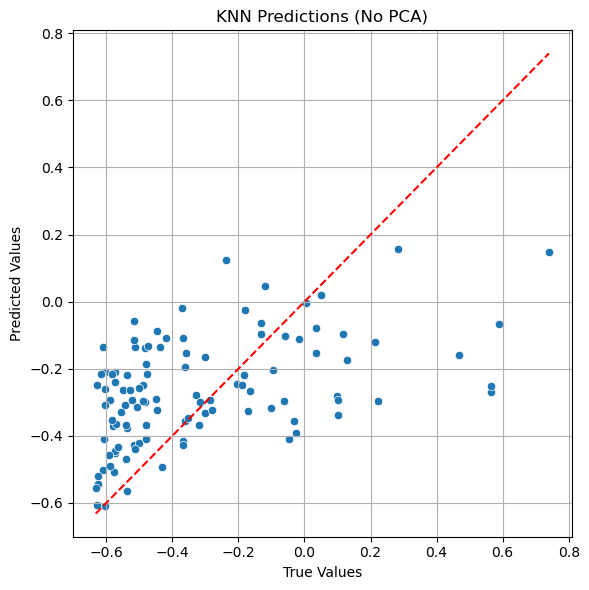

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("KNN Predictions (No PCA)")
plt.grid(True)
plt.tight_layout()
plt.show()
